In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'TRON'
yf_crypto = 'TRX'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,0.002304,0.002438,0.002285,0.002344,2924350
2017-11-10,0.002335,0.002350,0.001989,0.002013,2193620
2017-11-11,0.002026,0.002298,0.001890,0.002003,1748460
2017-11-12,0.002006,0.002006,0.001684,0.001783,2174370
2017-11-13,0.001795,0.002146,0.001771,0.002112,2889150


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-04,0.113434,0.114572,0.113136,0.114473,280842437
2024-06-05,0.114473,0.114776,0.113798,0.114636,239489525
2024-06-06,0.114636,0.115192,0.114008,0.114748,249335077
2024-06-07,0.114747,0.115096,0.111809,0.112711,397404842
2024-06-08,0.112702,0.115098,0.112314,0.114756,337196249


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

0.11475600302219391

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.993336,0.993701,0.992183,0.188175
High,0.993336,1.000000,0.986254,0.995380,0.230598
Low,0.993701,0.986254,1.000000,0.993850,0.156722
Close,0.992183,0.995380,0.993850,1.000000,0.200066
Volume,0.188175,0.230598,0.156722,0.200066,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2017-11-09,0.002344,2924350
2017-11-10,0.002013,2193620
2017-11-11,0.002003,1748460
2017-11-12,0.001783,2174370
2017-11-13,0.002112,2889150
...,...,...
2024-06-04,0.114473,280842437
2024-06-05,0.114636,239489525
2024-06-06,0.114748,249335077


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2017-12-28,0.041974,261940992,0.042059,0.021286,0.013622
2017-12-29,0.036348,246896992,0.041009,0.022428,0.014302
2017-12-30,0.036413,256698000,0.039762,0.023567,0.014990
2017-12-31,0.044752,375152000,0.039640,0.024988,0.015845
2018-01-01,0.051695,516798016,0.040902,0.026642,0.016844


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-06-04,0.114473,280842437,0.112780,0.119368,0.118177
2024-06-05,0.114636,239489525,0.112934,0.119234,0.118234
2024-06-06,0.114748,249335077,0.113163,0.119038,0.118334
2024-06-07,0.112711,397404842,0.113324,0.118699,0.118401
2024-06-08,0.114756,337196249,0.113604,0.118318,0.118498


<Axes: xlabel='Date'>

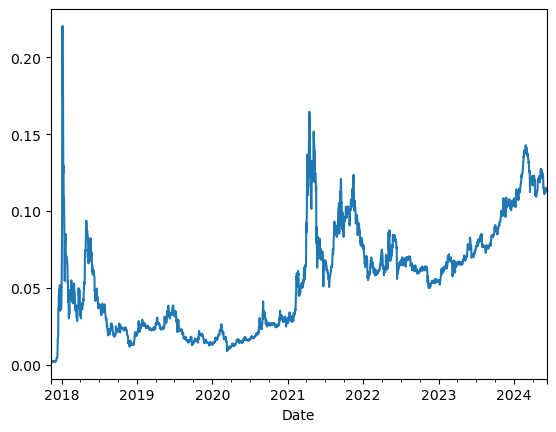

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2017-11-09,0.002344,2924350
1,2017-11-10,0.002013,2193620
2,2017-11-11,0.002003,1748460
3,2017-11-12,0.001783,2174370
4,2017-11-13,0.002112,2889150
...,...,...,...
2399,2024-06-04,0.114473,280842437
2400,2024-06-05,0.114636,239489525
2401,2024-06-06,0.114748,249335077
2402,2024-06-07,0.112711,397404842


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:26 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
2489,2024-09-02
2490,2024-09-03
2491,2024-09-04
2492,2024-09-05
2493,2024-09-06


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2464,2024-08-08,0.134342,0.111773,0.148180,0.133453,0.135392,-0.004149,-0.004149,-0.004149,0.000046,0.000046,0.000046,-0.004196,-0.004196,-0.004196,0.0,0.0,0.0,0.130192
2465,2024-08-09,0.134480,0.110706,0.149721,0.133570,0.135574,-0.004057,-0.004057,-0.004057,0.000079,0.000079,0.000079,-0.004137,-0.004137,-0.004137,0.0,0.0,0.0,0.130422
2466,2024-08-10,0.134618,0.110761,0.149399,0.133668,0.135762,-0.003847,-0.003847,-0.003847,0.000226,0.000226,0.000226,-0.004072,-0.004072,-0.004072,0.0,0.0,0.0,0.130771
2467,2024-08-11,0.134756,0.111987,0.149129,0.133774,0.135944,-0.003774,-0.003774,-0.003774,0.000230,0.000230,0.000230,-0.004004,-0.004004,-0.004004,0.0,0.0,0.0,0.130982
2468,2024-08-12,0.134894,0.112257,0.149920,0.133878,0.136118,-0.004105,-0.004105,-0.004105,-0.000172,-0.000172,-0.000172,-0.003933,-0.003933,-0.003933,0.0,0.0,0.0,0.130789
2469,2024-08-13,0.135032,0.112679,0.150600,0.133992,0.136301,-0.004150,-0.004150,-0.004150,-0.000289,-0.000289,-0.000289,-0.003861,-0.003861,-0.003861,0.0,0.0,0.0,0.130882
2470,2024-08-14,0.135170,0.113074,0.151247,0.134081,0.136519,-0.003909,-0.003909,-0.003909,-0.000120,-0.000120,-0.000120,-0.003788,-0.003788,-0.003788,0.0,0.0,0.0,0.131261
2471,2024-08-15,0.135308,0.112120,0.149197,0.134233,0.136721,-0.003670,-0.003670,-0.003670,0.000046,0.000046,0.000046,-0.003716,-0.003716,-0.003716,0.0,0.0,0.0,0.131638
2472,2024-08-16,0.135446,0.113509,0.150700,0.134356,0.136898,-0.003566,-0.003566,-0.003566,0.000079,0.000079,0.000079,-0.003645,-0.003645,-0.003645,0.0,0.0,0.0,0.131880
2473,2024-08-17,0.135584,0.113735,0.151204,0.134399,0.137060,-0.003351,-0.003351,-0.003351,0.000226,0.000226,0.000226,-0.003576,-0.003576,-0.003576,0.0,0.0,0.0,0.132234


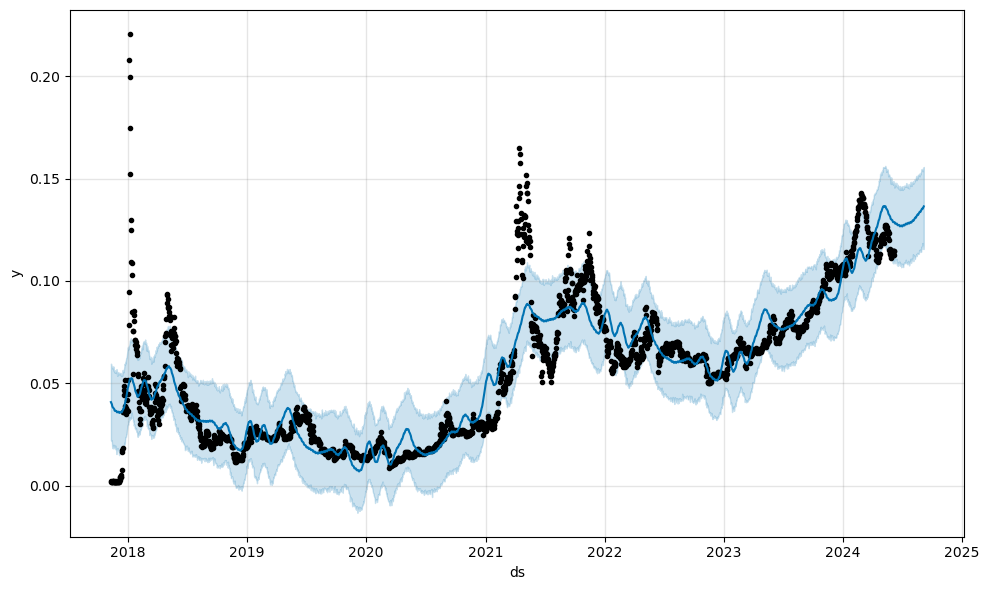

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,0.128616,0.111123,0.147220
2024-06-10,0.128112,0.110152,0.146802
2024-06-11,0.127896,0.108568,0.147997
2024-06-12,0.127966,0.109905,0.146348
2024-06-13,0.128034,0.110033,0.146620
...,...,...,...
2024-09-02,0.135176,0.118532,0.153991
2024-09-03,0.135299,0.117077,0.154921
2024-09-04,0.135711,0.117157,0.153605


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

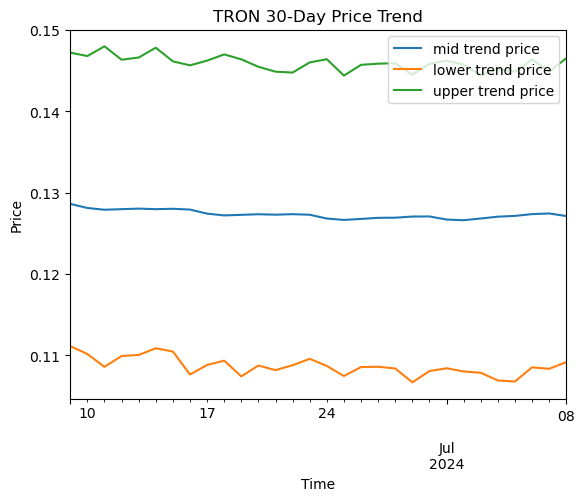

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

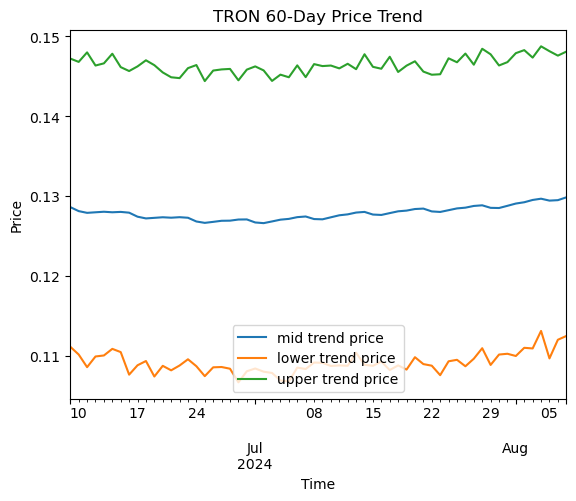

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

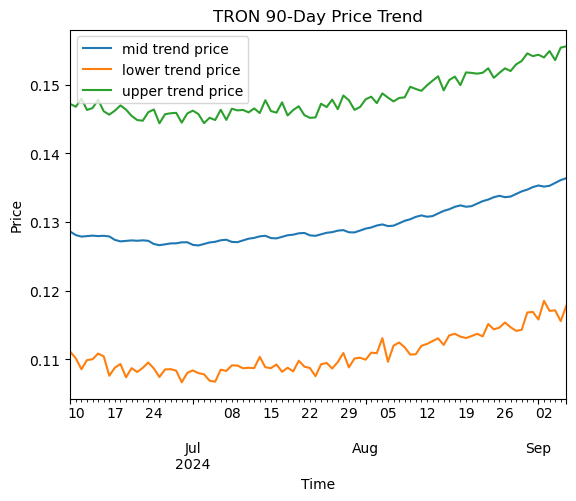

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

0.11475600302219391

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

0.1286155177674109

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

0.1216857603948024

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

0.12883791150575016

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

0.12732849360009874

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

0.13010614002812695

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

0.136525245295063

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

0.046

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

0.069

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.122

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

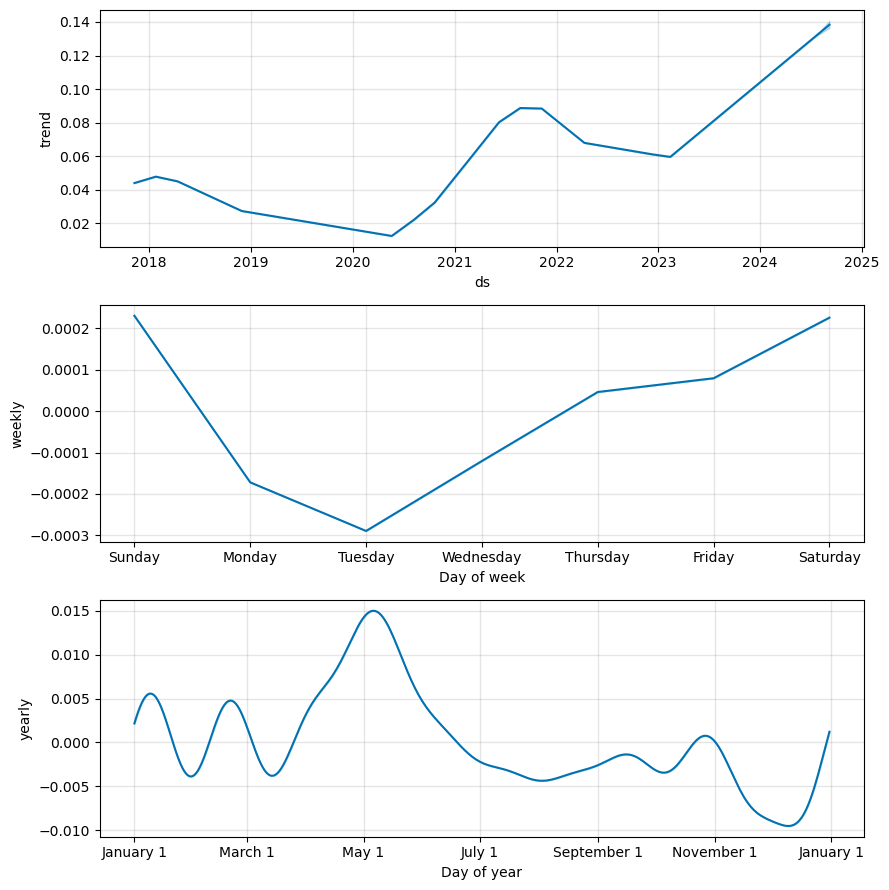

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

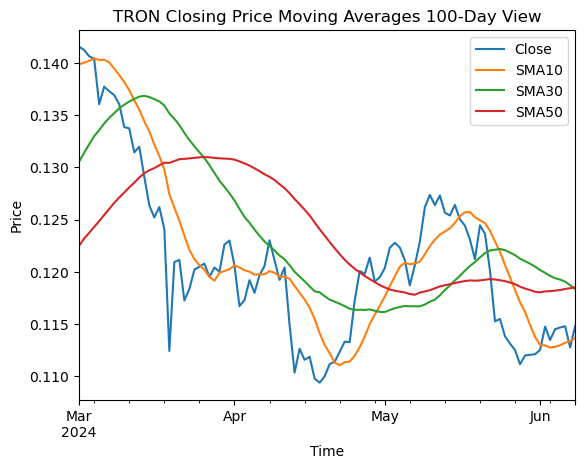

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

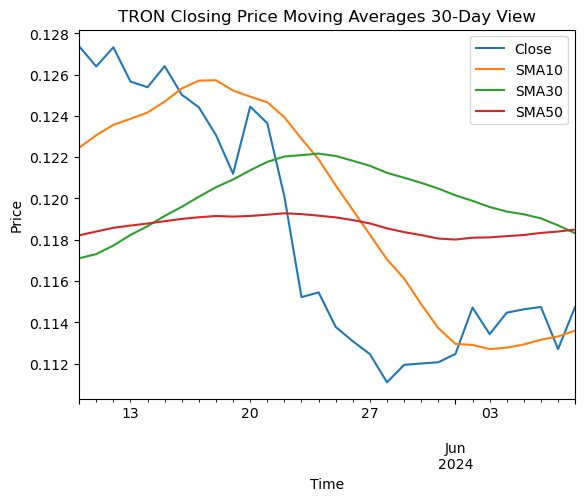

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')    
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.43657100200653076,-0.07364667494769794,-0.0009456964793739253,0.3544596118546628
ADA,0.43657100200653076,-0.08437373181845453,0.002834181787628731,0.36173019111251126
ADA,0.43657100200653076,-0.08372637062435029,0.0025919668069758206,0.3631142967037635
ADA,0.43657100200653076,-0.0783190338427533,0.004381382002310641,0.36321329122708335
ATOM,7.759523868560791,-0.2525451407294217,-0.22995154564524733,0.08676291965413196
AVAX,32.29003143310547,-0.06238204683353343,0.016250905637703372,0.184324988794629
AVAX,32.29003143310547,-0.061383912293528464,0.006255814491331391,0.188757389641659
BNB,682.6651611328125,-0.25945675235825627,-0.21619087415535265,-0.19462572272913758
BONK,2.700000004551839e-05,0.19694570130627698,0.3277996886564134,0.4415377509818921
BTC,69305.7734375,-0.1351637782567381,-0.09261706566887273,-0.09372540555309616
DOGE,0.14605900645256042,-0.18446710000937716,-0.08920949588743987,-0.03966410323402325
ETH,3680.949951171875,-0.11161221692021561,-0.03134563847923688,-0.